<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
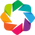

In [2]:
import os
import pandas as pd
import re
import holoviews as hv
import ipywidgets as widgets
from IPython.display import display
import ninetysix as ns
import numpy as np
hv.extension('bokeh')

In [3]:
def work_up_lcms(
    file,
    products,
    substrates=None,
    drop_string=None,
):
    """Works up a standard csv file from Revali.
    Parameters:
    -----------
    file: string
        Path to the csv file
    products: list of strings
        Name of the peaks that correspond to the product
    substrates: list of strings
        Name of the peaks that correspond to the substrate
    drop_string: string, default 'burn_in'
        Name of the wells to drop, e.g., for the wash/burn-in period that are not samples.
    Returns:
    --------
    plate: ns.Plate object (DataFrame-like)
    """
    # Read in the data
    df = pd.read_csv(file, header=[1])
    # Convert nans to 0
    df = df.fillna(0)
    # Only grab the Sample Acq Order No.s that have a numeric value
    index = [True for _ in df['Sample Acq Order No']]
    for i, value in enumerate(df['Sample Acq Order No']):
        try:
            int(value)
        except ValueError:
            index[i] = False
    # Index on this
    df = df[index]
    def fill_vial_number(series):
        for i, row in enumerate(series):
            if pd.isna(row):
                series[i] = series[i-1]
        return series
    df['Sample Vial Number'] = fill_vial_number(df['Sample Vial Number'].copy())
    # Remove unwanted wells
    df = df[df['Sample Name'] != drop_string]
    # Get wells
    df.insert(0, 'Well', df['Sample Vial Number'].apply(lambda x: x.split('-')[-1]))
    # Rename
    df = df.rename({'Sample Name': 'Plate'}, axis='columns')
    # Create minimal DataFrame
    df = df[['Well', 'Plate', 'Compound Name', 'Area']].reset_index(drop=True)
    # Pivot table; drop redundant values by only taking 'max' with aggfunc
    # (i.e., a row is (value, NaN, NaN) and df is 1728 rows long;
    # taking max to aggregate duplicates gives only (value) and 576 rows long)
    df = df.pivot_table(
        index=['Well', 'Plate'],
        columns='Compound Name',
        values='Area',
        aggfunc='max'
    ).reset_index()
    # Get rows and columns
    df.insert(1, 'Column', df['Well'].apply(lambda x: int(x[1:])))
    df.insert(1, 'Row', df['Well'].apply(lambda x: x[0]))
    # Set values as floats
    cols = products+substrates if substrates is not None else products
    for col in cols:
        df[col] = df[col].astype(float)
    plate = ns.Plate(df, value_name=products[-1]).set_as_location('Plate', idx=3)
    plate.values = products
    return plate

In [7]:
# Function to process the plate files
def process_plate_files(product):
    # Load the provided CSV file
    results_df = pd.read_csv('HMC0225_HMC0226.csv')

    # Extract the required columns: Plate, Well, Mutations, and nc_variant, and remove rows with '#N.A.#' and NaN values
    filtered_df = results_df[['Plate', 'Well', 'Mutations', 'nc_variant', 'aa_variant']]
    filtered_df = filtered_df[(filtered_df['Mutations'] != '#N.A.#')].dropna()

    # Extract the unique entries of Plate
    unique_plates = filtered_df['Plate'].unique()

    # Create an empty list to store the processed plate data
    processed_data = []

    # Iterate over unique Plates and search for corresponding CSV files in the current directory
    for plate in unique_plates:
        # Construct the expected filename based on the Plate value
        filename = f"{plate}.csv"
        
        # Check if the file exists in the current directory
        if os.path.isfile(filename):
            # Work up data to plate object
            plate_object = work_up_lcms(filename, product)
            
            # Extract attributes from plate_object as needed for downstream processes
            if hasattr(plate_object, 'df'):
                # Assuming plate_object has a dataframe-like attribute 'df' that we can work with
                plate_df = plate_object.df
                plate_df['Plate'] = plate  # Add the plate identifier for reference
                
                # Merge filtered_df with plate_df to retain Mutations and nc_variant columns
                merged_df = pd.merge(plate_df, filtered_df, on=['Plate', 'Well'], how='left')
                columns_order = ['Plate', 'Well', 'Row', 'Column', 'Mutations'] + product + ['nc_variant', 'aa_variant']
                merged_df = merged_df[columns_order]
                processed_data.append(merged_df)

    # Concatenate all dataframes if available
    if processed_data:
        processed_df = pd.concat(processed_data, ignore_index=True)
    else:
        processed_df = pd.DataFrame(columns=['Plate', 'Well', 'Row', 'Column', 'Mutations'] + product + ['nc_variant', 'aa_variant'])

    # Ensure all entries in 'Mutations' are treated as strings
    processed_df['Mutations'] = processed_df['Mutations'].astype(str)

    # Remove any rows with empty values
    processed_df = processed_df.dropna()

    # Optionally, save the processed DataFrame to a CSV file
    processed_df.to_csv('processed_plate_data.csv', index=False)

    # Create a subset of the processed DataFrame where only '#PARENT#' and variants are kept
    # parent_and_variant_df = processed_df[processed_df['Mutations'].isin(['#PARENT#']) | (processed_df['Mutations'] != '#N.A.#')]
    # parent_and_variant_df.to_csv('/group_files/levseq-sequence-function/HMC0225_HMC0226/Results/parent_and_variant_data.csv', index=False)

    # Return the processed DataFrame for downstream processes
    return processed_df

# Function to identify SSM experiments
def identify_ssm_experiments(df):
    # Function to identify if a mutation is part of an SSM experiment
    def is_ssm(mutation):
        # Define a regex pattern for detecting SSM: a single position with varying amino acids
        return bool(re.match(r"^[A-Z]\d+[A-Z]$", str(mutation)))

    # Add a new column indicating whether each mutation is part of an SSM experiment
    df['is_ssm'] = df['Mutations'].apply(is_ssm)
    return df

# Example usage of the function
processed_plate_df = process_plate_files(product=["pdt"])
#processed_plate_df = identify_ssm_experiments(processed_plate_df)
processed_plate_df

,Plate,Well,Row,Column,Mutations,pdt,nc_variant,aa_variant
1,HMC0225-P1,A2,A,2,#PARENT#,273777.8326,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
2,HMC0225-P1,A3,A,3,A59V,219122.0179,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
3,HMC0225-P1,A4,A,4,A59S,28506.2887,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
4,HMC0225-P1,A5,A,5,A59N,97889.0927,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
5,HMC0225-P1,A6,A,6,A59V,99170.9124,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
...,...,...,...,...,...,...,...,...
753,HMC0226-P12,G10,G,10,R90C,24019.3564,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
754,HMC0226-P12,G11,G,11,E84G,46228.5323,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGAGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
758,HMC0226-P12,H3,H,3,H187P,2827.8368,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGEEDVMYLKKAAD...
761,HMC0226-P12,H6,H,6,E35G,28526.3062,ATGACTCCCTCGGACATCTCGGGGTATGATTATGGGCGTGTCGAGA...,MTPSDISGYDYGRVEKSPITDLEFDLLKKTVMLGGEDVMYLKKAAD...
